In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, TensorDataset

import datetime
import os

import optuna
import torch.optim as optim

In [2]:
# read sno_test_set.txt to available_station
available_station = np.loadtxt('html.2023.final.data/sno_test_set.txt', dtype='str')
available_station

array(['500101001', '500101002', '500101003', '500101004', '500101005',
       '500101006', '500101007', '500101008', '500101009', '500101010',
       '500101013', '500101014', '500101015', '500101018', '500101019',
       '500101020', '500101021', '500101022', '500101023', '500101024',
       '500101025', '500101026', '500101027', '500101028', '500101029',
       '500101030', '500101031', '500101032', '500101033', '500101034',
       '500101035', '500101036', '500101037', '500101038', '500101039',
       '500101040', '500101041', '500101042', '500101091', '500101092',
       '500101093', '500101094', '500101114', '500101115', '500101123',
       '500101166', '500101175', '500101176', '500101181', '500101184',
       '500101185', '500101188', '500101189', '500101190', '500101191',
       '500101193', '500101199', '500101209', '500101216', '500101219',
       '500105066', '500106002', '500106003', '500106004', '500119043',
       '500119044', '500119045', '500119046', '500119047', '5001

In [4]:
folder_path = 'html.2023.final.data/release'  # replace with your actual folder path
available_date = os.listdir(folder_path)

def get_one_hot_weekday(date_str):
    # Convert the date string to a datetime object
    date = datetime.datetime.strptime(date_str, '%Y%m%d')
    
    # Get the weekday (Monday is 0, Sunday is 6)
    weekday = date.weekday()
    
    # Create a one-hot encoded list for the weekday
    one_hot_weekday = [1 if i == weekday else 0 for i in range(7)]
    
    return one_hot_weekday

def time_to_minute(time_str):
    hours, minutes = map(int, time_str.split(':'))
    total_minutes = hours * 60 + minutes
    return total_minutes

date_to_one_hot_weekday = {}
for date in available_date:
    date_to_one_hot_weekday[date] = [ x for x in get_one_hot_weekday(date)]

sbis = []
time = []
feature_num = 8
unit_time = 1
one_hot_weekday = []
dataset = pd.DataFrame()

# for date in available_date:
#     for station in available_station:
#         df = pd.read_json(f'html.2023.final.data/release/{date}/{station}.json', convert_axes=False)
#         df = df.transpose()
#         df = df.bfill().ffill()
#         df.reset_index(inplace=True)
#         df = df.rename(columns={'index': 'time'})
#         df['time'] = df['time'].apply(time_to_minute)
#         df[['mon','tue','wed','thu','fri','sat','sun']] = [date_to_one_hot_weekday[date]] * len(df)
#         df['station'] = [station] * len(df)
#         dataset = pd.concat([dataset,df], ignore_index=False)

using_station = 500101001
for date in available_date:
    df = pd.read_json(f'html.2023.final.data/release/{date}/{using_station}.json', convert_axes=False)
    df = df.transpose()
    df = df.bfill().ffill()
    df.reset_index(inplace=True)
    df = df.rename(columns={'index': 'time'})
    df['time'] = df['time'].apply(time_to_minute)
    df[['mon','tue','wed','thu','fri','sat','sun']] = [date_to_one_hot_weekday[date]] * len(df)
    df['station'] = [using_station] * len(df)
    dataset = pd.concat([dataset,df], ignore_index=False)


# pd.DataFrame.to_parquet(dataset, 'dataset.parquet')


In [5]:
df.columns

Index(['time', 'tot', 'sbi', 'bemp', 'act', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'sun', 'station'],
      dtype='object')

In [42]:
# get X, y
df = pd.read_parquet('dataset.parquet')
TOT = 28
df['sbi'] = df['sbi']/TOT
df['time'] = df['time']/1440

# x is dataset without 'sbi', y is 'sbi'
X = df.drop(['tot', 'sbi','bemp' ,'act', 'tot', 'station'], axis=1)
y = df['sbi']

X = X.to_numpy()
y = y.to_numpy()

X = torch.from_numpy(X)
y = torch.from_numpy(y)
dataset = TensorDataset(X, y)

# split train, test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# get train, test loader
train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=True)


# build the gradient boosting regression model with PyTorch
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        # Define your neural network here
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Define your neural network forward pass here
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        # Define your custom loss function here
        # This is a simple example, replace it with your own function
        custom_loss = 3*(torch.abs(labels - outputs))*(torch.abs(labels - 1/3) + torch.abs(labels -2/3))
        return custom_loss

AttributeError: 'list' object has no attribute 'DataLoader'

In [45]:
X.shape


torch.Size([72000, 8])

In [38]:
# train the model
model = Net(8, 4096, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.reshape(-1)
        loss = criterion(outputs, labels).sum()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.6f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            
print('Finished Training')


[1,   100] loss: 0.075271
[1,   200] loss: 0.063514
[1,   300] loss: 0.060414
[1,   400] loss: 0.060102
[2,   100] loss: 0.057716
[2,   200] loss: 0.055509
[2,   300] loss: 0.056227
[2,   400] loss: 0.052882
[3,   100] loss: 0.053319
[3,   200] loss: 0.053719
[3,   300] loss: 0.051929
[3,   400] loss: 0.049346
[4,   100] loss: 0.053319
[4,   200] loss: 0.050084
[4,   300] loss: 0.049915
[4,   400] loss: 0.049289
[5,   100] loss: 0.049340
[5,   200] loss: 0.050421
[5,   300] loss: 0.050711
[5,   400] loss: 0.047059
[6,   100] loss: 0.047375
[6,   200] loss: 0.050172
[6,   300] loss: 0.048488
[6,   400] loss: 0.047017
[7,   100] loss: 0.046906
[7,   200] loss: 0.046000
[7,   300] loss: 0.047288
[7,   400] loss: 0.046695
[8,   100] loss: 0.044679
[8,   200] loss: 0.045952
[8,   300] loss: 0.046293
[8,   400] loss: 0.046046
[9,   100] loss: 0.046606
[9,   200] loss: 0.046594
[9,   300] loss: 0.044800
[9,   400] loss: 0.043674
[10,   100] loss: 0.044780
[10,   200] loss: 0.045059
[10,   300

In [39]:
# test the model
# calculate with custom loss
def custom_error(outputs, labels):
    return 3*(torch.abs(labels - outputs))*(torch.abs(labels - 1/3) + torch.abs(labels -2/3))

total_loss = 0
for i, data in enumerate(test_loader):
    inputs, labels = data
    inputs = inputs.float()
    labels = labels.float()
    outputs = model(inputs).reshape(-1)
    # use custom loss
    loss = custom_error(outputs, labels).sum()
    total_loss += loss

batch 1 loss: 0.247001
batch 2 loss: 0.305211
batch 3 loss: 0.264058
batch 4 loss: 0.276309
batch 5 loss: 0.266097
batch 6 loss: 0.298638
batch 7 loss: 0.275172
batch 8 loss: 0.312751
batch 9 loss: 0.251341
batch 10 loss: 0.291081
batch 11 loss: 0.271888
batch 12 loss: 0.236799
batch 13 loss: 0.264099
batch 14 loss: 0.301312
batch 15 loss: 0.271257
batch 16 loss: 0.270566
batch 17 loss: 0.283505
batch 18 loss: 0.294367
batch 19 loss: 0.258521
batch 20 loss: 0.273198
batch 21 loss: 0.247406
batch 22 loss: 0.274148
batch 23 loss: 0.282783
batch 24 loss: 0.269160
batch 25 loss: 0.268907
batch 26 loss: 0.284202
batch 27 loss: 0.280383
batch 28 loss: 0.281709
batch 29 loss: 0.287912
batch 30 loss: 0.282800
batch 31 loss: 0.286821
batch 32 loss: 0.248958
batch 33 loss: 0.244954
batch 34 loss: 0.307432
batch 35 loss: 0.316979
batch 36 loss: 0.261991
batch 37 loss: 0.262702
batch 38 loss: 0.262284
batch 39 loss: 0.322188
batch 40 loss: 0.239256
batch 41 loss: 0.258613
batch 42 loss: 0.256980
b

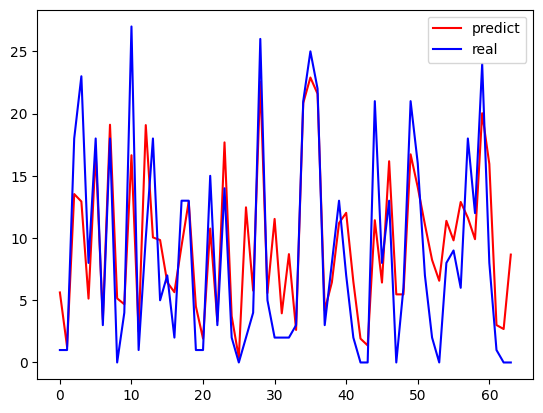

In [40]:
t1 = t1.detach().numpy()
t2 = t2.detach().numpy()
plt.plot(t1, label='predict', color = 'red')
plt.plot(t2, label='real', color = 'blue')
plt.legend()
plt.show()



In [51]:
first35_station = available_station[:35]
first35_station

array(['500101001', '500101002', '500101003', '500101004', '500101005',
       '500101006', '500101007', '500101008', '500101009', '500101010',
       '500101013', '500101014', '500101015', '500101018', '500101019',
       '500101020', '500101021', '500101022', '500101023', '500101024',
       '500101025', '500101026', '500101027', '500101028', '500101029',
       '500101030', '500101031', '500101032', '500101033', '500101034',
       '500101035', '500101036', '500101037', '500101038', '500101039'],
      dtype='<U9')

In [25]:
# get X, y
df = pd.read_parquet('dataset.parquet')
TOT = 28
df['sbi'] = df['sbi']/TOT
df['time'] = df['time']/1440

# x is dataset without 'sbi', y is 'sbi'
X = df.drop(['tot', 'sbi','bemp' ,'act', 'tot', 'station'], axis=1)
y = df['sbi']

X = X.to_numpy()
y = y.to_numpy()

X = torch.from_numpy(X)
y = torch.from_numpy(y)
dataset = TensorDataset(X, y)

# split train, test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# get train, test loader
train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=True)

# build the gradient boosting regression model with PyTorch
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out
    
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        # Define your custom loss function here
        # This is a simple example, replace it with your own function
        custom_loss = 3*(torch.abs(labels - outputs))*(torch.abs(labels - 1/3) + torch.abs(labels -2/3))
        return custom_loss


# ...

# Define the Optuna objective function
def objective(trial):
    # Sample hyperparameters
    input_size = 8
    hidden_size = trial.suggest_int('hidden_size', 3, 10000, log=True)  # Single hidden size for all layers
    output_size = 1
    learning_rate = trial.suggest_float('learning_rate', 1e-7, 1e1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.7)

    # Instantiate the model with sampled hyperparameters
    model = Net(input_size, hidden_size, output_size, dropout_rate)

    # Define the loss function and optimizer
    criterion = CustomLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(100):
        training_loss = 0.0
        eval_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.float()
            labels = labels.float()
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.reshape(-1)
            loss = criterion(outputs, labels).sum()
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        model.eval()
        # Iterate over the DataLoader for test data
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                inputs, labels = data
                inputs = inputs.float()
                labels = labels.float()
                outputs = model(inputs).reshape(-1)
                loss = criterion(outputs, labels).sum()
                eval_loss += loss

        # Optuna logs the running loss for each epoch
        trial.report(eval_loss, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Return the running loss as the objective value to minimize
    return eval_loss


In [28]:
# Create an Optuna Study
using_station = 500101001
study = optuna.create_study(direction='minimize', storage='sqlite:///db.sqlite3', study_name=f'{using_station}')

# Run the optimization process
study.optimize(objective, n_trials=50)

# Access the best hyperparameters
best_params = study.best_trial.params
print('Best hyperparameters:', best_params)



[I 2023-12-01 14:42:40,342] A new study created in RDB with name: 500101001
[I 2023-12-01 14:43:08,120] Trial 0 finished with value: 5764.0732421875 and parameters: {'num_layers': 3, 'hidden_size': 57, 'learning_rate': 0.8167306877837324, 'dropout_rate': 0.5926224981861072}. Best is trial 0 with value: 5764.0732421875.
[I 2023-12-01 14:43:35,609] Trial 1 finished with value: 5747.6533203125 and parameters: {'num_layers': 4, 'hidden_size': 36, 'learning_rate': 0.11917838822404833, 'dropout_rate': 0.3322119590000635}. Best is trial 1 with value: 5747.6533203125.
[I 2023-12-01 14:45:09,207] Trial 2 finished with value: 5777.17626953125 and parameters: {'num_layers': 5, 'hidden_size': 4727, 'learning_rate': 2.5416736760696947, 'dropout_rate': 0.5629634422738523}. Best is trial 1 with value: 5747.6533203125.
[I 2023-12-01 14:46:04,123] Trial 3 finished with value: 3742.68505859375 and parameters: {'num_layers': 2, 'hidden_size': 2259, 'learning_rate': 0.00031133154510835047, 'dropout_rate':

Best hyperparameters: {'num_layers': 2, 'hidden_size': 3376, 'learning_rate': 0.0029403555426387768, 'dropout_rate': 0.0018062640232380939}


TypeError: Net.__init__() missing 3 required positional arguments: 'hidden_size', 'output_size', and 'dropout_rate'

In [81]:
# get X, y
df = pd.read_parquet('dataset.parquet')
TOT = 28
df['sbi'] = df['sbi']/TOT
df['time'] = df['time']/1440

# x is dataset without 'sbi', y is 'sbi'
X = df.drop(['tot', 'sbi','bemp' ,'act', 'tot', 'station'], axis=1)
y = df['sbi']

X = X.to_numpy()
y = y.to_numpy()

X = torch.from_numpy(X)
y = torch.from_numpy(y)
dataset = TensorDataset(X, y)

# get train, test loader
all_data_loader = torch.utils.data.DataLoader(dataset, batch_size = 128, shuffle=True)

# Instantiate the final model with the best hyperparameters
print(best_params.keys())
final_model = Net(8, best_params['hidden_size'], 1, best_params['dropout_rate'])

# ... rest of your training code for the final model
criterion = CustomLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

# train with whole dataset
running_loss = 0.0
for epoch in range(20):
    for i, data in enumerate(all_data_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        optimizer.zero_grad()
        outputs = final_model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels).sum()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()/128
    print(f'epoch: {epoch+1}, loss: {running_loss/all_data_loader.__len__()}')
    running_loss = 0.0

final_model.eval()
# save model
torch.save(final_model.state_dict(), f'models/model_{using_station}.pt')


dict_keys(['num_layers', 'hidden_size', 'learning_rate', 'dropout_rate'])
epoch: 0, loss: 0.3635465969359684
epoch: 1, loss: 0.31035925479701737
epoch: 2, loss: 0.29165332006095357
epoch: 3, loss: 0.2840844672537189
epoch: 4, loss: 0.27951406839685794
epoch: 5, loss: 0.2757081785115213
epoch: 6, loss: 0.27502642725437193
epoch: 7, loss: 0.27392134311250005
epoch: 8, loss: 0.271901988472333
epoch: 9, loss: 0.2708220649411369
epoch: 10, loss: 0.2701147651005384
epoch: 11, loss: 0.2695456630753793
epoch: 12, loss: 0.2698515879642053
epoch: 13, loss: 0.2688152865501746
epoch: 14, loss: 0.2686289425800368
epoch: 15, loss: 0.26774531332891743
epoch: 16, loss: 0.2665735161854996
epoch: 17, loss: 0.2667158149434237


KeyboardInterrupt: 

In [4]:
class station_model():
    def __init__(self, station):
        self.station = station

    def get_data_loader(self):
        df = pd.read_parquet(f'parquets/{self.station}.parquet')
        TOT = df['tot'].iloc[0]
        df['sbi'] = df['sbi']/TOT
        df['time'] = df['time']/1440

        # x is dataset without 'sbi', y is 'sbi'
        X = df.drop(['tot', 'sbi','bemp' ,'act', 'tot', 'station'], axis=1)
        y = df['sbi']

        X = X.to_numpy()
        y = y.to_numpy()

        X = torch.from_numpy(X)
        y = torch.from_numpy(y)
        dataset = TensorDataset(X, y)

        # get train, test loader
        self.all_data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

        # split train, test
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        # get train, test loader
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)
        print(f'get data loader for {self.station}')

    def objective(self,trial):
        # Sample hyperparameters
        input_size = 8
        hidden_size = trial.suggest_int('hidden_size', 3, 10000, log=True)  # Single hidden size for all layers
        output_size = 1
        learning_rate = trial.suggest_float('learning_rate', 1e-7, 1e1, log=True)
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.7)

        # Instantiate the model with sampled hyperparameters
        model = Net(input_size, hidden_size, output_size, dropout_rate)

        # Define the loss function and optimizer
        criterion = CustomLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop
        for epoch in range(100):
            training_loss = 0.0
            eval_loss = 0.0
            # Iterate over the DataLoader for training data
            for i, data in enumerate(self.train_loader):
                inputs, labels = data
                inputs = inputs.float()
                labels = labels.float()
                optimizer.zero_grad()
                outputs = model(inputs)
                outputs = outputs.reshape(-1)
                loss = criterion(outputs, labels).sum()
                loss.backward()
                optimizer.step()
                training_loss += loss.item()

            model.eval()
            # Iterate over the DataLoader for test data
            with torch.no_grad():
                for i, data in enumerate(self.test_loader):
                    inputs, labels = data
                    inputs = inputs.float()
                    labels = labels.float()
                    outputs = model(inputs).reshape(-1)
                    loss = criterion(outputs, labels).sum()
                    eval_loss += loss

            # Optuna logs the running loss for each epoch
            trial.report(eval_loss, epoch)
            # Handle pruning based on the intermediate value
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        # Return the running loss as the objective value to minimize
        return eval_loss      


    def get_best_param(self):
        # Create an Optuna Study
        study = optuna.create_study(direction='minimize', storage='sqlite:///db.sqlite3', study_name=f'{self.station}', load_if_exists=True)

        # Run the optimization process
        study.optimize(self.objective, n_trials=50)

        print(f'{self.station} eval_loss: {study.best_trial.value}')

        # Access the best hyperparameters
        best_params = study.best_trial.params

        self.best_params = best_params

        print(self.station,' Best hyperparameters:', best_params)

    def train(self):
        # Instantiate the final model with the best hyperparameters
        final_model = Net(8, self.best_params['hidden_size'], 1, self.best_params['dropout_rate'])

        # ... rest of your training code for the final model
        criterion = CustomLoss()
        optimizer = optim.Adam(final_model.parameters(), lr=self.best_params['learning_rate'])

        # train with whole dataset
        running_loss = 0.0
        for epoch in range(20):
            for i, data in enumerate(self.all_data_loader):
                inputs, labels = data
                inputs = inputs.float()
                labels = labels.float()
                optimizer.zero_grad()
                outputs = final_model(inputs)
                outputs = outputs.squeeze()
                loss = criterion(outputs, labels).sum()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()/128
            print(f'epoch: {epoch+1}, loss: {running_loss/self.all_data_loader.__len__()}')
            running_loss = 0.0

        final_model.eval()
        # save model
        torch.save(final_model.state_dict(), f'models/model_{self.station}.pt')

In [5]:
available_station = np.loadtxt('html.2023.final.data/sno_test_set.txt', dtype='str')
first35_station = available_station[:35]

for station_id in first35_station:
    station = station_model(station_id)
    station.get_data_loader()
    station.get_best_param()
    station.train()
    print(f'{station_id} done')

get data loader for 500101001


[I 2023-12-02 12:54:37,720] Using an existing study with name '500101001' instead of creating a new one.
[W 2023-12-02 12:54:37,775] Trial 50 failed with parameters: {'hidden_size': 1543, 'learning_rate': 0.0057020209914659765, 'dropout_rate': 0.33804936906957256} because of the following error: NameError("name 'Net' is not defined").
Traceback (most recent call last):
  File "/Users/yl/Library/Caches/pypoetry/virtualenvs/html-qsiNAWFM-py3.11/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/l8/cns8rbyx5y17d2vn6gf6qkk80000gn/T/ipykernel_66548/1530220195.py", line 44, in objective
    model = Net(input_size, hidden_size, output_size, dropout_rate)
            ^^^
NameError: name 'Net' is not defined
[W 2023-12-02 12:54:37,776] Trial 50 failed with value None.


NameError: name 'Net' is not defined

In [3]:
# load model from /models
# build the gradient boosting regression model with PyTorch
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out
    
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        # Define your custom loss function here
        # This is a simple example, replace it with your own function
        custom_loss = 3*(torch.abs(labels - outputs))*(torch.abs(labels - 1/3) + torch.abs(labels -2/3))
        return custom_loss


# ...

# Define the Optuna objective function
def objective(trial):
    # Sample hyperparameters
    input_size = 8
    hidden_size = trial.suggest_int('hidden_size', 3, 10000, log=True)  # Single hidden size for all layers
    output_size = 1
    learning_rate = trial.suggest_float('learning_rate', 1e-7, 1e1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.7)

    # Instantiate the model with sampled hyperparameters
    model = Net(input_size, hidden_size, output_size, dropout_rate)

    # Define the loss function and optimizer
    criterion = CustomLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(100):
        training_loss = 0.0
        eval_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.float()
            labels = labels.float()
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.reshape(-1)
            loss = criterion(outputs, labels).sum()
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        model.eval()
        # Iterate over the DataLoader for test data
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                inputs, labels = data
                inputs = inputs.float()
                labels = labels.float()
                outputs = model(inputs).reshape(-1)
                loss = criterion(outputs, labels).sum()
                eval_loss += loss

        # Optuna logs the running loss for each epoch
        trial.report(eval_loss, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Return the running loss as the objective value to minimize
    return eval_loss
model = Net(8, 4096, 1)
model.load_state_dict(torch.load('models/model_500101001.pt'))

NameError: name 'nn' is not defined